In [1]:
import os
import pypsa
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
EXTERNAL = "/Volumes/T9"
PYPSA = os.path.abspath(os.path.join(os.getcwd(), "../..")) + '/pypsa-eur'
RESOURCES = PYPSA + "/resources/"
DATA = PYPSA +  "/data/"
CUTOUT = PYPSA + "/cutouts/"

In [3]:
x_min, x_max = -12., 35.     
y_min, y_max = 33., 65.
date_0 = datetime(1000, 6, 15, 0)
date_1 = datetime(1000, 8, 15, 23)

In [4]:
his_era5_ncfile = xr.open_dataset(EXTERNAL + f"/era5/heatwave_july/Historical_era5_July_data.nc")
his_rcp45_ncfile = xr.open_dataset(EXTERNAL + f"/rcp45/Historical_rcp45_July_data.nc")
fut_rcp45_ncfile = xr.open_dataset(EXTERNAL + f"/rcp45/Future_rcp45_July_data.nc")
delta_temp_ncfile = xr.open_dataset(EXTERNAL + f"/era5/Historical_delta_heatwave_July_data.nc")

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units


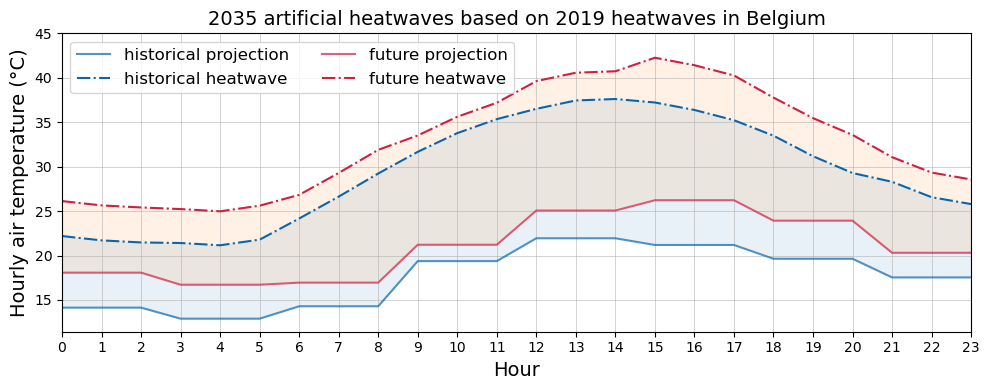

In [7]:
for selected_country in  ['BE']: #[ 'BE', 'IT', 'ES', 'FR', 'GB', 'DE']: 
    rcp = 45
    if selected_country in ['GB', 'FR',]:
        ratio = 50
    elif selected_country in ['DE','IT']:
        ratio = 75
    elif selected_country in ['ES']:
        ratio = 25
    elif selected_country in ['BE']:
        ratio = 100
    if ratio < 100:
        network_filename = RESOURCES + f"{selected_country}/networks/elec_s_{ratio}.nc"  
    else:
        network_filename = RESOURCES + f"{selected_country}/networks/elec_s.nc"  
    network = pypsa.Network(network_filename)


    for fut_year in [2035]:#[2025, 2030, 2035, 2040, 2045, 2050]:
        his_year = 2019
        date_s = datetime(his_year-2, 6, 1, 0)
        date_e = datetime(his_year+2, 8, 31, 23)
        his_era5_ncfile_slice = his_era5_ncfile.sel(time=slice(date_s, date_e))
        his_rcp45_ncfile_slice = his_rcp45_ncfile.sel(time=slice(date_s, date_e))
        his_delta_temp_slice = delta_temp_ncfile.sel(time=slice(date_s, date_e))
        fut_rcp45_ncfile_slice = fut_rcp45_ncfile.sel(time=slice(datetime(fut_year, date_s.month, date_s.day, date_s.hour), 
                                                            datetime(fut_year, date_e.month, date_e.day, date_e.hour)))

        bus_his_era5_temp = []
        bus_his_rcp45_temp = []
        bus_fut_rcp45_temp = []
        bus_fut_delta_temp = []
        bus_loc_list = network.buses[['x','y']].values
        x_da = xr.DataArray(bus_loc_list[:,0], dims=["bus"])
        y_da = xr.DataArray(bus_loc_list[:,1], dims=["bus"])

        bus_his_era5_temp = his_era5_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - 273.15
        bus_his_rcp45_temp = his_rcp45_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - 273.15
        bus_fut_rcp45_temp = fut_rcp45_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - 273.15
        bus_fut_delta_temp = his_delta_temp_slice.sel(x=x_da, y=y_da, method='nearest')['delta_temp'].data 

        bus_his_rcp45_temp = np.stack([bus_his_rcp45_temp,bus_his_rcp45_temp,bus_his_rcp45_temp],axis=1).reshape(-1, len(bus_loc_list))
        bus_fut_rcp45_temp = np.stack([bus_fut_rcp45_temp,bus_fut_rcp45_temp,bus_fut_rcp45_temp],axis=1).reshape(-1, len(bus_loc_list))

        ### find those hottest days with highest spatially-average temperature
        hot_index = bus_his_era5_temp.mean(1).argmax()//24
        future_hot_index = bus_fut_rcp45_temp.mean(1).argmax()//24

        ### visualize the spatial-average temperature
        historical_baseline = bus_his_rcp45_temp[hot_index*24: hot_index*24+24, :].mean(1)
        historical_heatwave = bus_his_era5_temp[hot_index*24: hot_index*24+24, :].mean(1)
        future_baseline = bus_fut_rcp45_temp[future_hot_index*24: future_hot_index*24+24, :].mean(1)
        delta_temp = bus_fut_delta_temp[hot_index*24: hot_index*24+24, :].mean(1) 
        future_heatwave = future_baseline + delta_temp

        plt.figure(figsize=[10,4])
        plt.fill_between(range(24), historical_baseline, historical_heatwave, alpha=0.1)
        plt.plot(historical_baseline, label='historical projection', c='#0B65AC', alpha=0.7)
        plt.plot(historical_heatwave, label='historical heatwave', c='#0B65AC', linestyle = '-.')
        country_name = {'BE': 'Belgium', 'IT': 'Italy', 'ES': 'Spain', 'GB': 'UK', 'FR': 'France', 'DE': 'Germany'}

        plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.1)
        plt.plot(future_baseline, label='future projection', c='#D11F40', alpha=0.7)
        plt.plot(future_heatwave, label='future heatwave', c='#D11F40', linestyle = '-.')
        plt.xlim(0, 23)
        plt.xticks(range(24))
        plt.yticks(range(15,50,5))
        plt.title(f'{fut_year} artificial heatwaves based on {his_year} heatwaves in {country_name[selected_country]}', fontsize=14)
        plt.xlabel('Hour',fontsize=14)
        plt.ylabel('Hourly air temperature (°C)', fontsize=14)
        plt.grid(linewidth=0.4)
        plt.legend(ncol=2, loc=2,  fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.abspath(os.path.join(os.getcwd(), "..")) + f'/models/heatwave/heatwave_{selected_country}_{fut_year}_{his_year}.png', dpi=300)
        plt.show()
        # plt.close()

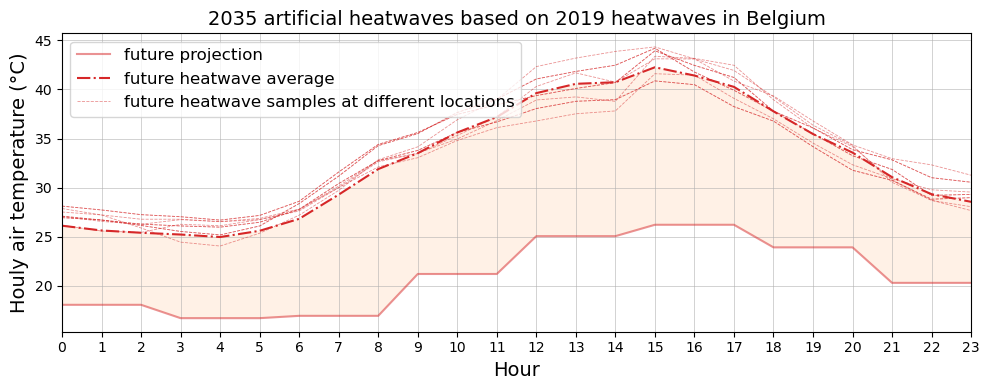

In [8]:
"""
for hottest days, plot all locations, to visualize spatial variations
"""

### find those hottest days with highest spatially-average temperature
hot_index = bus_his_era5_temp.mean(1).argmax()//24
future_hot_index = bus_fut_rcp45_temp.mean(1).argmax()//24

# historical_baseline = bus_his_rcp45_temp[hot_index*24: hot_index*24+24, :].mean(1)
# historical_heatwave = bus_his_era5_temp[hot_index*24: hot_index*24+24, :].mean(1)
future_baseline = bus_fut_rcp45_temp[future_hot_index*24: future_hot_index*24+24, :].mean(1)
delta_temp = bus_fut_delta_temp[hot_index*24: hot_index*24+24, :]
historical_delta_temp = []
# sample 10 locations
for i in range(10):
    historical_delta_temp.append(delta_temp[:, i])
historical_delta_temp = np.stack(historical_delta_temp, axis=1)

plt.figure(figsize=[10,4])
plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.)
plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.1)
plt.plot(future_baseline, label='future projection', c='C3', alpha=0.5)
plt.plot(future_heatwave, label='future heatwave average', c='C3', linestyle = '-.')

for i in range(historical_delta_temp.shape[1]):
    future_heatwave = future_baseline + historical_delta_temp[:,i]
    plt.plot(future_heatwave, label=None, c='C3', linestyle = 'dashed', linewidth=0.6, alpha=0.5)

plt.plot([], label='future heatwave samples at different locations', c='C3', linestyle = 'dashed', linewidth=0.6, alpha=0.5)

plt.xlim(0, 23)
plt.xticks(range(24))
# plt.yticks(range(15,50,5))
plt.title(f'{fut_year} artificial heatwaves based on {his_year} heatwaves in {country_name[selected_country]}', fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Houly air temperature (°C)', fontsize=14)
plt.grid(linewidth=0.4)
plt.legend(ncol=1, loc=2,  fontsize=12)
plt.tight_layout()


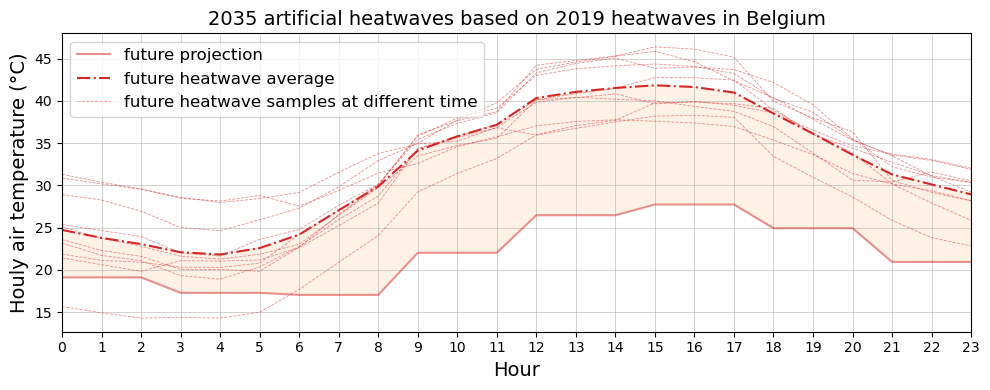

In [9]:
"""
for single location, plot those hottest days, to visualize temporal variations
""" 
bus_index = 2
hot_index = bus_his_era5_temp.mean(1)[14::24].argsort()[::-1]
future_hot_index = bus_fut_rcp45_temp.mean(1).argmax()//24

# historical_baseline = bus_his_rcp45_temp[hot_index*24: hot_index*24+24, bus_index].mean(1)
# historical_heatwave = bus_his_era5_temp[hot_index*24: hot_index*24+24, bus_index].mean(1)
future_baseline = bus_fut_rcp45_temp[future_hot_index*24: future_hot_index*24+24, bus_index]
historical_delta_temp = []

### consider top 10 historically hottest day for future heatwave generation
for i in hot_index[:10]:
    delta_temp = bus_fut_delta_temp[i*24: i*24+24, bus_index] 
    historical_delta_temp.append(delta_temp)
historical_delta_temp = np.stack(historical_delta_temp, axis=0)
future_heatwave = future_baseline + historical_delta_temp.mean(0)

plt.figure(figsize=[10,4])
plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.)
plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.1)
plt.plot(future_baseline, label='future projection', c='C3', alpha=0.5)
plt.plot(future_heatwave, label='future heatwave average', c='C3', linestyle = '-.')

for i in range(historical_delta_temp.shape[0]):
    future_heatwave = future_baseline + historical_delta_temp[i]
    plt.plot(future_heatwave, label=None, c='C3', linestyle = 'dashed', linewidth=0.6, alpha=0.5)

plt.plot([], label='future heatwave samples at different time', c='C3', linestyle = 'dashed', linewidth=0.6, alpha=0.5)

plt.xlim(0, 23)
plt.xticks(range(24))
# plt.yticks(range(15,50,5))
plt.title(f'{fut_year} artificial heatwaves based on {his_year} heatwaves in {country_name[selected_country]}', fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Houly air temperature (°C)', fontsize=14)
plt.grid(linewidth=0.4)
plt.legend(ncol=1, loc=2,  fontsize=12)
plt.tight_layout()